## GAN 실습해보기

- data : MNIST

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# device setting for gpu users
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
torch.backends.cudnn.enabled = False

device:  cuda


### 2. DATA LOAD

In [23]:
epochs = 300
batch_size = 128
z_dim = 100

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5, ),std=(0.5, ))])
mnist_dataset = datasets.MNIST(root = './data/', train = True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

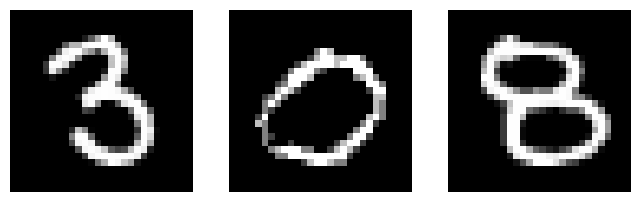

In [24]:
#Random visualization 잘 로드 되었나!
figure = plt.figure(figsize=(8,8))
cols, rows = 3,1
for i in range(1, cols*rows+1):
    #0 이상 len미만의 정수중 무작위 1개 선정 -> Tensor로 반환
    # .item() 하나의 값만인 텐서에서 정수를 꺼내 int/float로 반환
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item() 
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") #hide x axis, y axis
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### 3.Modeling

In [25]:
class Generator(nn.Module):
    def __init__(self, latent_dims, momentum=0.8):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims

        self.fc1 = nn.Linear(latent_dims, 128)
        self.bn1 = nn.BatchNorm1d(128, momentum = momentum)

        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256, momentum = momentum)

        self.fc3 = nn.Linear(256,512)
        self.bn3 = nn.BatchNorm1d(512, momentum = momentum)

        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024, momentum = momentum)

        self.fc5 = nn.Linear(1024, 784)

        self.initialize()

    def initialize(self):
        #모델 xavier 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        #Relu -> leaky로 변경해봄!
        z = self.bn1(F.leaky_relu(self.fc1(z), negative_slope=0.2))
        z = self.bn2(F.leaky_relu(self.fc2(z), negative_slope=0.2))
        z = self.bn3(F.leaky_relu(self.fc3(z), negative_slope=0.2))
        z = self.bn4(F.leaky_relu(self.fc4(z), negative_slope=0.2))
        z = self.fc5(z)
        return z

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 256) #512층 추가
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

        self.initialize()

    def initialize(self):
        #모델 xavier 초기화
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        #ReLU -> leaky 변경
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = self.fc3(x)
        return torch.sigmoid(x)

In [27]:
generator = Generator(latent_dims = z_dim).to(device)
discriminator = Discriminator().to(device)
print("Generator :", generator)
print("Discriminator :",discriminator)

Generator : Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator : Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


### 4.train

In [28]:
def train_model(latent_dims, discriminator, generator, 
                batch_size, dis_optimizer, gen_optimizer, 
                criterion, dataloader, epochs, device):
    #고정된 랜덤 백터            
    testing_random_latent = torch.randn(5, latent_dims).to(device)

    # ✅ loss 기록용 리스트
    dis_loss_list = []
    gen_loss_list = []

    for epoch in range(epochs):
        epoch_dis_loss = 0.0
        epoch_gen_loss = 0.0
        num_batches = 0

        #배치 단위로 이미지 로드
        for batch_index, (batch_images, _) in enumerate(dataloader):
            num_batches += 1

            #실제 이미지는 1, fake는 0 라벨 생성
            reals = torch.ones(batch_size, 1).to(device)
            fakes = torch.zeros(batch_size, 1).to(device)

            #이미지를 1차원 벡터로 변환
            batch_images = batch_images.view(batch_size, -1).to(device)

            ## DISCRIMINATOR 학습 ##
            #Real Image에 대한 discrim의출력
            dis_results = discriminator(batch_images)
            dis_real_loss = criterion(dis_results, reals) #1에 가깝게 loss

            #Fake Image 생성
            latent = torch.randn(batch_size, latent_dims).to(device)
            fake_images = generator(latent).detach() #생성기 기울기 차단

            #fake image에 대한 discrim의 출력
            dis_results = discriminator(fake_images)
            dis_fake_loss = criterion(dis_results, fakes) #0에 가깝게 loss

            #discrim 총 loss
            dis_total_loss = dis_real_loss + dis_fake_loss

            #discrim param 업데이트
            discriminator.zero_grad() #이전 기울기 초기화
            dis_total_loss.backward() 
            dis_optimizer.step() #param업데이트

            ## Generator 학습 ##
            #Fake Image 생성
            latent = torch.randn(batch_size, latent_dims).to(device)
            fake_images = generator(latent) 

            #fake image에 대한 discrim의 출력
            dis_results = discriminator(fake_images)

            #generator loss
            #fake가 real에 분류되도록 (1에 가깝게)
            #-log(D(G(z))) 최소화
            ###논문은 log(1-D(G(z)))를 최소화 하지만, 초기에 기울기가 너무 작아 학습이 작다. 
            ###이를 -log(D(g(z)))를 최소화 = log(D(g(z)))를 최대화
            gen_loss = criterion(dis_results, reals) #실제에 대해 가짜를 구별 못하게

            #generator param 업데이트
            generator.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            # ✅ epoch별 평균을 위한 누적
            epoch_dis_loss += dis_total_loss.item()
            epoch_gen_loss += gen_loss.item()
            
        # ✅ epoch 평균 loss 저장
        dis_loss_list.append(epoch_dis_loss / num_batches)
        gen_loss_list.append(epoch_gen_loss / num_batches)

        
        if epoch % 20 == 0:
            print(f"EPOCH {epoch}: Discriminator Loss: {dis_loss_list[-1]:.4f}, Generator Loss: {gen_loss_list[-1]:.4f}")

            with torch.no_grad():
                #고정된 벡터로 test image 생성
                testing_fake_images = generator(testing_random_latent)
                testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().detach().numpy() #1.Numpy 배열을 변환하려면 cpu로 이동해서!

                #Visualization
                plt.figure(figsize=(10,5))
                plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
                for i in range(5):
                    plt.subplot(1, 5, int(i) + 1)
                    plt.imshow(testing_fake_images[i], cmap='gray')
                plt.show()

    return discriminator, generator, dis_loss_list, gen_loss_list

In [29]:
criterion = nn.BCELoss()
generator_optim = torch.optim.Adam(generator.parameters(), lr = 0.002, betas = (0.5, 0.999)) 
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas = (0.5, 0.999))

EPOCH 0: Discriminator Loss: 1.3546, Generator Loss: 1.3886


/tmp/ipykernel_55875/3051221125.py:89: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, int(i) + 1)


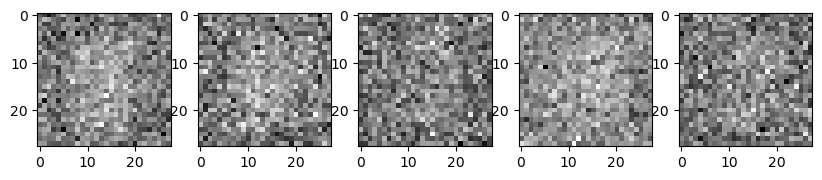

EPOCH 20: Discriminator Loss: 1.0016, Generator Loss: 1.9714


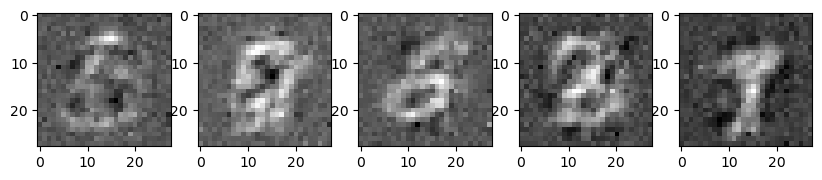

EPOCH 40: Discriminator Loss: 1.0224, Generator Loss: 2.0564


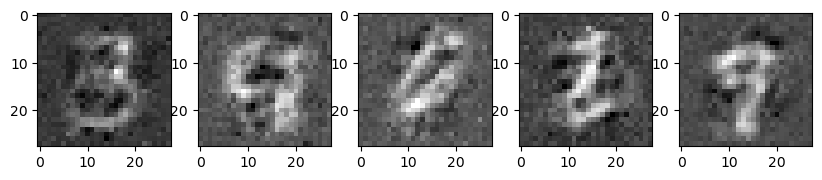

EPOCH 60: Discriminator Loss: 1.0295, Generator Loss: 2.2307


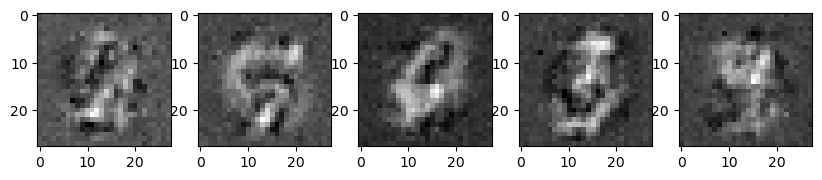

EPOCH 80: Discriminator Loss: 1.0016, Generator Loss: 2.2760


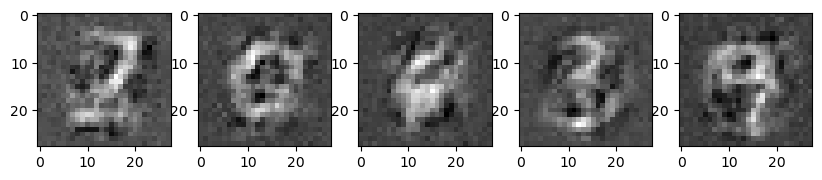

EPOCH 100: Discriminator Loss: 0.9628, Generator Loss: 2.4511


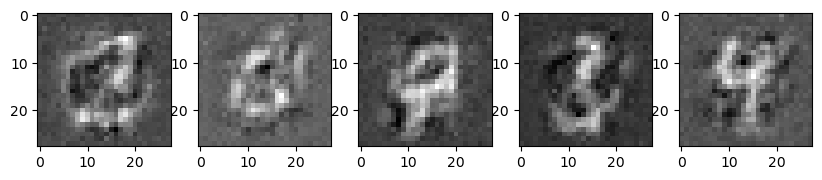

EPOCH 120: Discriminator Loss: 0.9969, Generator Loss: 2.4834


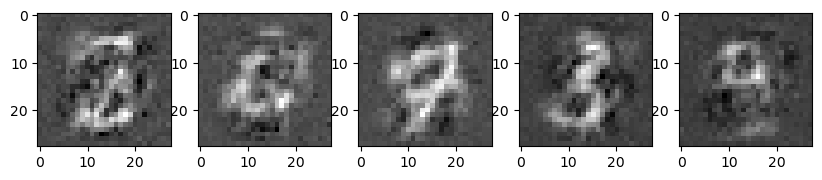

EPOCH 140: Discriminator Loss: 1.0104, Generator Loss: 2.5731


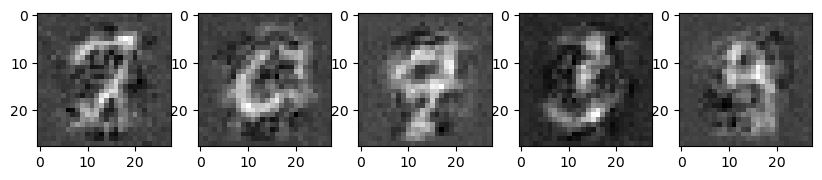

EPOCH 160: Discriminator Loss: 0.9880, Generator Loss: 2.7584


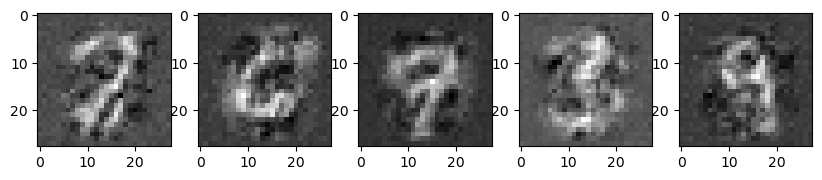

EPOCH 180: Discriminator Loss: 0.9616, Generator Loss: 2.7708


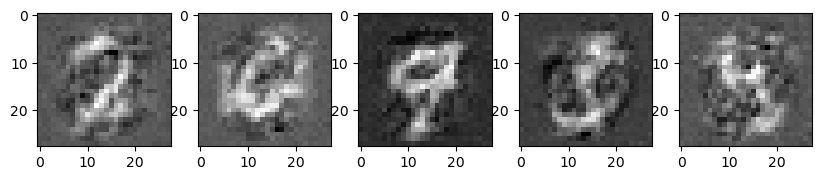

EPOCH 200: Discriminator Loss: 0.8876, Generator Loss: 2.8733


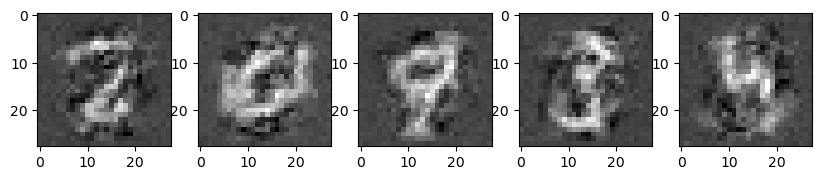

EPOCH 220: Discriminator Loss: 0.9919, Generator Loss: 2.7534


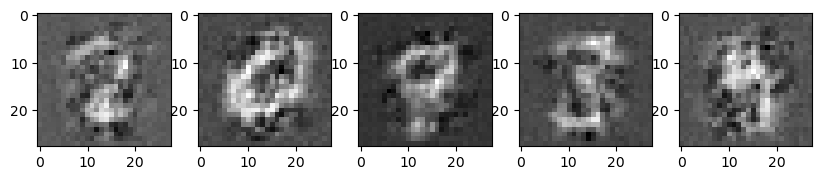

EPOCH 240: Discriminator Loss: 0.8932, Generator Loss: 2.9371


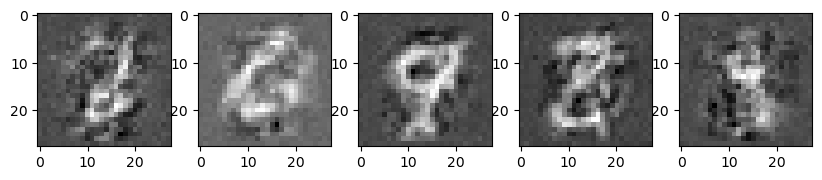

EPOCH 260: Discriminator Loss: 0.8667, Generator Loss: 3.0562


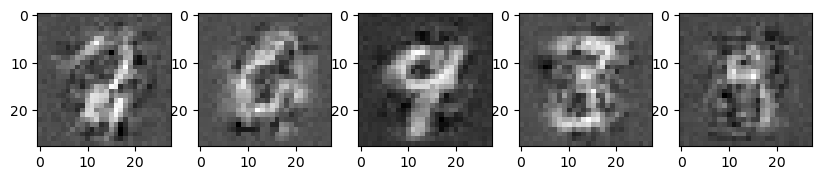

EPOCH 280: Discriminator Loss: 0.9228, Generator Loss: 2.9109


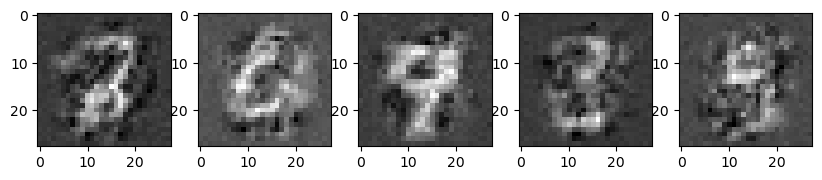

In [30]:
#진짜 (1), 가짜(0)의 라벨을 붙여준다.
discriminator, generator, dis_losses, gen_losses = train_model(z_dim, discriminator, generator, batch_size, discriminator_optim, generator_optim, criterion, dataloader, epochs, device)

In [31]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

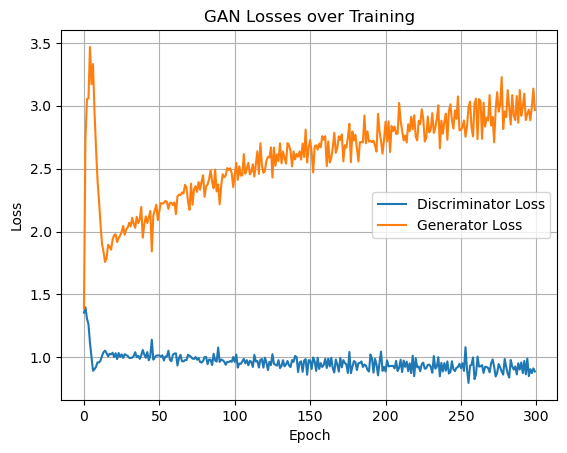

In [32]:
# Loss그래프 그리기
import matplotlib.pyplot as plt
plt.plot(dis_losses, label="Discriminator Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Losses over Training")
plt.legend()
plt.grid(True)
plt.show()

### 5.Evaluation

In [33]:
G = Generator(latent_dims=z_dim).to(device)
G.load_state_dict(torch.load("G.ckpt", map_location=device))
G.eval()  # 평가 모드로 설정

/tmp/ipykernel_55875/4011423156.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("G.ckpt", map_location=device))


Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=1024, out_features=784, bias=True)
)

In [34]:
# 100개의 latent 벡터 생성 (배치 크기=100)
z = torch.randn(100, 100).to(device)  # [batch_size, z_dim]

with torch.no_grad():
    fake_images = G(z)  # shape: [100, 1, 28, 28]


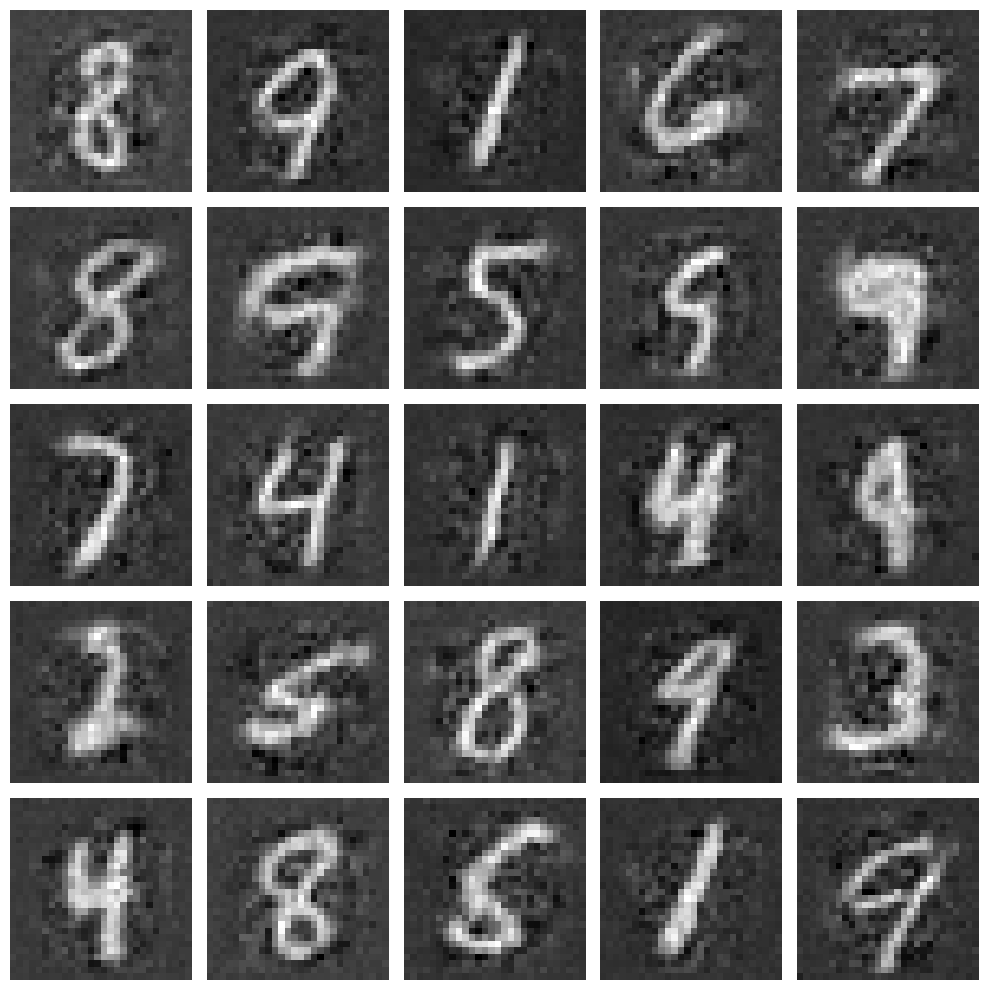

In [35]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(fake_images[i].cpu().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()